# Introduction
This tutorial shows how a H2O [Deep Learning](http://en.wikipedia.org/wiki/Deep_learning) model can be used to do supervised classification and regression. This tutorial covers usage of H2O from R. A python version of this tutorial will be available as well in a separate document. This file is available in plain R, R markdown and regular markdown formats, and the plots are available as PDF files. More examples and explanations can be found in our [H2O Deep Learning booklet](http://h2o.ai/resources/) and on our [H2O Github Repository](http://github.com/h2oai/h2o-3/).


### H2O Python Module

Load the H2O Python module.

In [1]:
import h2o


### Start H2O
Start up a 1-node H2O server on your local machine, and allow it to use all CPU cores and up to 2GB of memory:

In [2]:
h2o.init(max_mem_size_GB = 2)            #uses all cores by default
h2o.remove_all()                          #clean slate, in case cluster was already running

H2O cluster uptime:,2 hours 38 minutes 14 seconds 656 milliseconds
H2O cluster version:,3.7.0.3248
H2O cluster name:,H2O_started_from_python
H2O cluster total nodes:,1
H2O cluster total memory:,1.78 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


To learn more about the h2o package itself, we can use Python's builtin help() function.

In [3]:
help(h2o)

Help on package h2o:

NAME
    h2o

FILE
    d:\anaconda\lib\site-packages\h2o\__init__.py

DESCRIPTION
    The H2O Python Module
    
    This module provides access to the H2O JVM, as well as its extensions, objects,
    machine-learning algorithms, and modeling support capabilities, such as basic
    munging and feature generation.
    
    The H2O JVM uses a web server so that all communication occurs on a socket (specified
    by an IP address and a port) via a series of REST calls (see connection.py for the REST
    layer implementation and details). There is a single active connection to the H2O JVM at
    any time, and this handle is stashed out of sight in a singleton instance of
    :class:`H2OConnection` (this is the global  :envvar:`__H2OConn__`). In other words,
    this package does not rely on Jython, and there is no direct manipulation of the JVM.
    
    The H2O python module is not intended as a replacement for other popular machine learning
    frameworks such as sc

help() can be used on H2O functions and models. Jupyter's builtin shift-tab functionality also works

In [4]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
help(H2ODeepLearningEstimator)
help(h2o.import_file)

Help on class H2ODeepLearningEstimator in module h2o.estimators.deeplearning:

class H2ODeepLearningEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Method resolution order:
 |      H2ODeepLearningEstimator
 |      h2o.estimators.estimator_base.H2OEstimator
 |      h2o.model.model_base.ModelBase
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_id=None, overwrite_with_best_model=None, checkpoint=None, use_all_factor_levels=None, activation=None, hidden=None, epochs=None, train_samples_per_iteration=None, seed=None, adaptive_rate=None, rho=None, epsilon=None, rate=None, rate_annealing=None, rate_decay=None, momentum_start=None, momentum_ramp=None, momentum_stable=None, nesterov_accelerated_gradient=None, input_dropout_ratio=None, hidden_dropout_ratios=None, l1=None, l2=None, max_w2=None, initial_weight_distribution=None, initial_weight_scale=None, loss=None, distribution=None, tweedie_power=None, score_interval=None, score_training_samples=

##H2O Deep Learning
While H2O Deep Learning has many parameters, it was designed to be just as easy to use as the other supervised training methods in H2O. Early stopping, automatic data standardization and handling of categorical variables and missing values and adaptive learning rates (per weight) reduce the amount of parameters the user has to specify. Often, it's just the number and sizes of hidden layers, the number of epochs and the activation function and maybe some regularization techniques.


### Let's have some fun first: Decision Boundaries
We start with a small dataset representing red and black dots on a plane, arranged in the shape of two nested spirals. Then we task H2O's machine learning methods to separate the red and black dots, i.e., recognize each spiral as such by assigning each point in the plane to one of the two spirals.

We visualize the nature of H2O Deep Learning (DL), H2O's tree methods (GBM/DRF) and H2O's generalized linear modeling (GLM) by plotting the decision boundary between the red and black spirals:

In [5]:
%matplotlib inline                        
#IMPORT ALL THE THINGS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

First, we need to upload our datasets to the the H2O cluster. The data is imported into H2OFrames, which operate similarly in function to pandas DataFrames.  

In this case, the cluster is running on our laptops. Data files are imported by their relative locations to this notebook.

In [6]:
spiral = h2o.upload_file("../data/spiral.csv")
grid  = h2o.upload_file("../data/grid.csv")


Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


Spiral is a simple data set consisting of two spirals of black and red dots.  
Grid is a 201 by 201 matrix with dimensions [-1.5, 1.5] by [-1.5, 1.5].

To visualize these datasets, we can pull them from H2OFrames into pandas DataFrames for easier plotting.

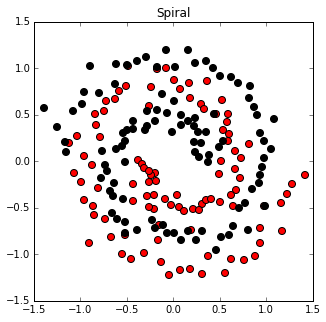

In [7]:
spiral_df = spiral.as_data_frame(use_pandas=True)
grid_df = grid.as_data_frame(use_pandas=True)
grid_x, grid_y = grid_df.x.reshape(201,201), grid_df.y.reshape(201,201)
spiral_r = spiral_df[spiral_df.color == "Red"]
spiral_k = spiral_df[spiral_df.color == "Black"]

spiral_xr, spiral_yr = spiral_r[spiral_r.columns[0]], spiral_r[spiral_r.columns[1]]
spiral_xk, spiral_yk = spiral_k[spiral_k.columns[0]], spiral_k[spiral_k.columns[1]]
    
markersize_ = 7**2
plt.figure(figsize = (5,5))
plt.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
plt.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title("Spiral");

###Model Construction
H2O in Python is designed to be very similar in look and feel to to scikit-learn. Models are initialized individually with desired or default parameters and then trained on data.  

Note that the below examples use model.train(), as opposed the traditional model.fit()
This is because h2o-py takes the data frame AND column indices for the feature and response columns, while scikit-learn takes in feature frames.

H2O supports model.fit() so that it can be incorporated into a scikit-learn pipeline, but we advise using train() in all other cases.

In [8]:
X = spiral.col_names[0:2]
y = spiral.col_names[2]
dl_model = H2ODeepLearningEstimator(epochs=1000)
dl_model.train(X, y, spiral)

gbm_model = H2OGradientBoostingEstimator()
gbm_model.train(X, y, spiral)

drf_model = H2ORandomForestEstimator()
drf_model.train(X, y, spiral)

glm_model = H2OGeneralizedLinearEstimator(family="binomial")
glm_model.fit(spiral[X], spiral[y])                                #model.fit() example

models = [dl_model, gbm_model, drf_model, glm_model]
m_names = ["Deep Learning", "Gradient Boosted Method", "Distributed Random Forest", "Generalized Linear Model"]



deeplearning Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%


D:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: UserWarning: 

	`fit` is not recommended outside of the sklearn framework. Use `train` instead.


Now that we've trained four models to classify points as red or black based on their (x,y) coordinates.  
To see how our models have performed, we ask them to predict the colors of the grid.

Below are four graphs of the contour plots of the predictions, so that we can see how exactly the algorithms grouped the points into black and red.

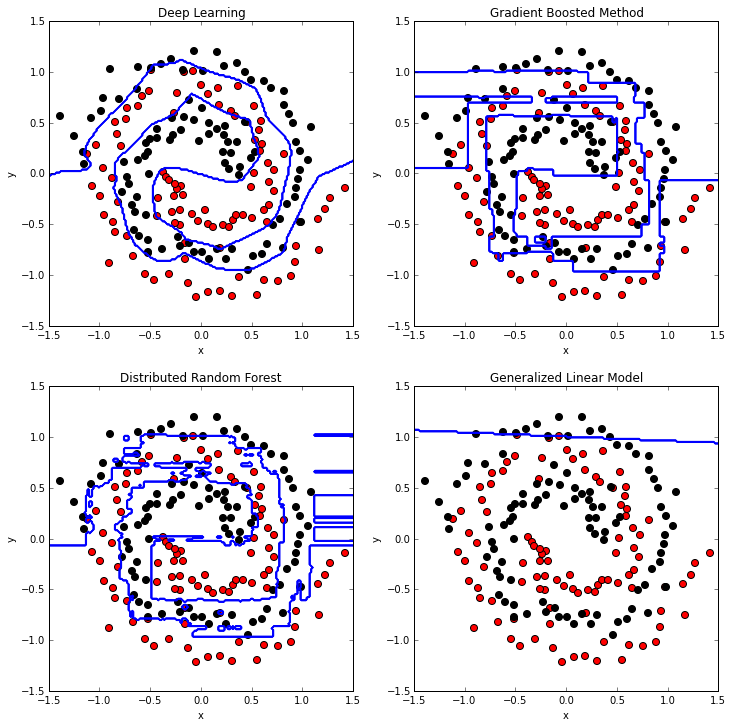

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
for k, subplot in enumerate(ax.flatten()):
    subplot.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
    subplot.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
    subplot.axis([-1.5, 1.5, -1.5, 1.5])
    subplot.set_title(m_names[k])
    subplot.set_xlabel('x')
    subplot.set_ylabel('y')
    pred_z = models[k].predict(grid).as_data_frame(True)
    subplot.contour(grid_x, grid_y, (pred_z['predict'] == 'Black').astype(np.int).reshape(201,201), colors='b')

###A Deeper Dive into Deep Learning

Now let's explore the evolution of our deep learning model over training time (number of passes over the data, aka epochs).  
We will use checkpointing to ensure that we continue training the same model

In [20]:
dl_200 = H2ODeepLearningEstimator(epochs=200)
dl_200.train(X, y, spiral)

dl_500 = H2ODeepLearningEstimator(checkpoint=dl_200, epochs = 500)
dl_500.train(X, y, spiral)

dl_750 = H2ODeepLearningEstimator(checkpoint=dl_500, epochs = 500)
dl_750.train(X, y, spiral)

dl_1000 = H2ODeepLearningEstimator(checkpoint=dl_750, epochs = 1000)
dl_1000.train(X, y, spiral)


deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1446836648403_50

Status of Neuron Layers: predicting color, 2-class classification, bernoulli distribution, CrossEntropy loss, 41,202 weights/biases, 490.7 KB, 40,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,2,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.1,0.2
,3,200,Rectifier,0.0,0.0,0.0,0.4,0.3,0.0,-0.0,0.1,0.7,0.4
,4,2,Softmax,,0.0,0.0,0.0,0.0,0.0,0.0,0.4,-0.0,0.0




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.294802452192
R^2: -0.179209808766
LogLoss: 1.30907903003
AUC: 0.7055
Gini: 0.411

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.364796551793:


,Black,Red,Error,Rate
Black,35.0,65.0,0.65,(65.0/100.0)
Red,0.0,100.0,0.0,(0.0/100.0)
Total,35.0,165.0,0.325,(65.0/200.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4,0.8,164.0
max f2,0.4,0.9,164.0
max f0point5,0.5,0.7,154.0
max accuracy,0.5,0.675,154.0
max precision,1.0,1.0,0.0
max absolute_MCC,0.4,0.5,164.0
max min_per_class_accuracy,1.0,0.61,98.0



Scoring History:


,timestamp,duration,training_speed,epochs,samples,training_MSE,training_r2,training_logloss,training_AUC,training_classification_error
,2015-11-06 13:58:41,0.000 sec,None,0.0,0.0,nan,nan,nan,nan,nan
,2015-11-06 13:58:41,0.313 sec,6493 rows/sec,10.0,2000.0,0.4,-0.6,1.4,0.5021,0.5
,2015-11-06 13:58:44,2.978 sec,13472 rows/sec,200.0,40000.0,0.3,-0.2,1.3,0.7055,0.325



deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1446836648403_52

Status of Neuron Layers: predicting color, 2-class classification, bernoulli distribution, CrossEntropy loss, 41,202 weights/biases, 490.7 KB, 100,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,2,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.3
,3,200,Rectifier,0.0,0.0,0.0,0.3,0.3,0.0,-0.0,0.2,0.8,0.5
,4,2,Softmax,,0.0,0.0,0.0,0.0,0.0,0.0,0.4,-0.0,0.0




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.100290182831
R^2: 0.598839268676
LogLoss: 0.313880315603
AUC: 0.9639
Gini: 0.9278

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.810291762483:


,Black,Red,Error,Rate
Black,91.0,9.0,0.09,(9.0/100.0)
Red,7.0,93.0,0.07,(7.0/100.0)
Total,98.0,102.0,0.08,(16.0/200.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8,0.9,97.0
max f2,0.8,0.9,97.0
max f0point5,1.0,0.9,72.0
max accuracy,0.8,0.92,97.0
max precision,1.0,1.0,0.0
max absolute_MCC,0.8,0.8,97.0
max min_per_class_accuracy,0.8,0.91,94.0



Scoring History:


,timestamp,duration,training_speed,epochs,samples,training_MSE,training_r2,training_logloss,training_AUC,training_classification_error
,2015-11-06 13:58:46,0.000 sec,None,0.0,0.0,nan,nan,nan,nan,nan
,2015-11-06 13:58:47,0.306 sec,6644 rows/sec,10.0,2000.0,0.5,-0.8,1.5,0.3696,0.5
,2015-11-06 13:58:52,5.334 sec,16153 rows/sec,430.0,86000.0,0.2,0.3,0.6,0.8971,0.195
,2015-11-06 13:58:52,5.967 sec,16798 rows/sec,500.0,100000.0,0.1,0.6,0.3,0.9639,0.08



deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1446836648403_54

Status of Neuron Layers: predicting color, 2-class classification, bernoulli distribution, CrossEntropy loss, 41,202 weights/biases, 490.7 KB, 100,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,2,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.3,0.1,0.4
,3,200,Rectifier,0.0,0.0,0.0,0.2,0.3,0.0,-0.1,0.2,0.8,0.5
,4,2,Softmax,,0.0,0.0,0.0,0.0,0.0,0.0,0.4,-0.0,0.1




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.119130750533
R^2: 0.523476997868
LogLoss: 0.36508762846
AUC: 0.963
Gini: 0.926

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.908980289064:


,Black,Red,Error,Rate
Black,92.0,8.0,0.08,(8.0/100.0)
Red,12.0,88.0,0.12,(12.0/100.0)
Total,104.0,96.0,0.1,(20.0/200.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.9,0.9,95.0
max f2,0.1,0.9,143.0
max f0point5,0.9,0.9,84.0
max accuracy,0.9,0.9,95.0
max precision,1.0,1.0,0.0
max absolute_MCC,0.9,0.8,95.0
max min_per_class_accuracy,0.9,0.88,95.0



Scoring History:


,timestamp,duration,training_speed,epochs,samples,training_MSE,training_r2,training_logloss,training_AUC,training_classification_error
,2015-11-06 13:58:55,0.000 sec,None,0.0,0.0,nan,nan,nan,nan,nan
,2015-11-06 13:58:55,0.293 sec,6944 rows/sec,10.0,2000.0,0.3,-0.3,1.5,0.6519,0.445
,2015-11-06 13:59:00,5.306 sec,18123 rows/sec,480.0,96000.0,0.1,0.5,0.4,0.963,0.1
,2015-11-06 13:59:00,5.484 sec,18274 rows/sec,500.0,100000.0,0.1,0.5,0.5,0.956,0.11
,2015-11-06 13:59:00,5.491 sec,18264 rows/sec,500.0,100000.0,0.1,0.5,0.4,0.963,0.1



deeplearning Model Build Progress: [##################################################] 100%


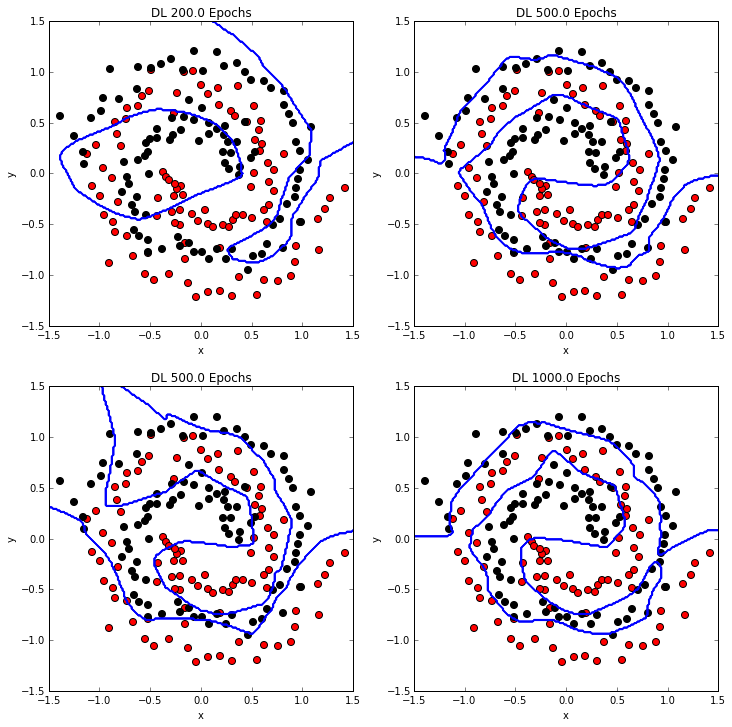

In [19]:
models_dl = [dl_200, dl_500, dl_750, dl_1000]
m_names_dl = ["DL " + str(model.get_params()['epochs']['actual_value']) + " Epochs" for model in models_dl]

fig, ax = plt.subplots(2,2, figsize=(12,12))
for k, subplot in enumerate(ax.flatten()):
    subplot.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
    subplot.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
    subplot.axis([-1.5, 1.5, -1.5, 1.5])
    subplot.set_title(m_names_dl[k])
    subplot.set_xlabel('x')
    subplot.set_ylabel('y')
    pred_z = models_dl[k].predict(grid).as_data_frame(True)
    subplot.contour(grid_x, grid_y, (pred_z['predict'] == 'Black').astype(np.int).reshape(201,201), colors='b')

###Shutdown H2O Cluster
Shut down the cluster now that we are done using it.

In [16]:
dl_200.get_params()['epochs']['actual_value']

200.0